In [4]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
# import seaborn as sns

# from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import colorbar as cbar
from matplotlib import cbook as cbook
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf
from pyspark.sql.functions import year, month, dayofmonth, hour, minute

import warnings
warnings.filterwarnings("ignore")

# sns.set_style("white")
# sns.set_color_codes()

In [34]:
def maplist(self, i):
    return self.rdd.map(lambda x: x[i]).collect()

In [5]:
from pyspark.sql.types import *

customSchema = StructType([ 
    StructField("IncidntNum", StringType(), True), 
    StructField("Category", StringType(), True), 
    StructField("Description", StringType(), True), 
    StructField("DayOfWeek", StringType(), True), 
    StructField("Date_str", StringType(), True), 
    StructField("Time_str", StringType(), True), 
    StructField("District", StringType(), True), 
    StructField("Resolution", StringType(), True), 
    StructField("Address", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("PdId", StringType(), True), ])

In [6]:
crimeDFsource = spark.read.csv('s3a://davidsx/dataSFcrime/', header=True, schema = customSchema)

In [37]:
from pyspark.sql.functions import to_timestamp, concat_ws

crimeDF = crimeDFsource.withColumn("DateTime_str", concat_ws(' ',crimeDFsource.Date_str,crimeDFsource.Time_str))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'MM/dd/yyyy HH:mm').cast(TimestampType()))\

crimeDF = crimeDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("DayOfMonth",dayofmonth("Datetime")).withColumn("Hour", hour("Datetime"))\
.withColumn("Minute", minute("Datetime")).where(col('Year')!=2018)

crimeDF = crimeDF.drop('Date_str','Time_str','DateTime_str','Resolution','Location','PdId')
crimeDF.printSchema()

root
 |-- IncidntNum: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Datetime: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)



In [38]:
crimeDF.cache()
sqlContext.registerDataFrameAsTable(crimeDF, 'df')

# Crime with effect on Month and Year

In [134]:
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

In [197]:
data = crimeDF.where((col('Year').isNotNull())&(col('Month').isNotNull()))\
.groupBy('Year','Month').count().orderBy('Year','Month')

In [198]:
year = np.asarray([2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017])
xlen = len(year)
month = np.asarray(['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December'])
ylen = len(month)
count = data.rdd.map(lambda x:x[2]).collect()
clen = len(count)

In [199]:
img = np.asarray(count,dtype=float)
#calculation of index between 0 and 1
maxc = np.amax(img)
minc = np.amin(img)
flow = maxc - minc
# np.subtract(img,np.repeat(np.amax(img),clen))
# np.divide(img,np.repeat(np.amax(img)-np.amin(img),clen))
for i in range(len(img)):
    img[i] = (img[i]-minc)/flow

img = img.reshape(ylen,xlen)

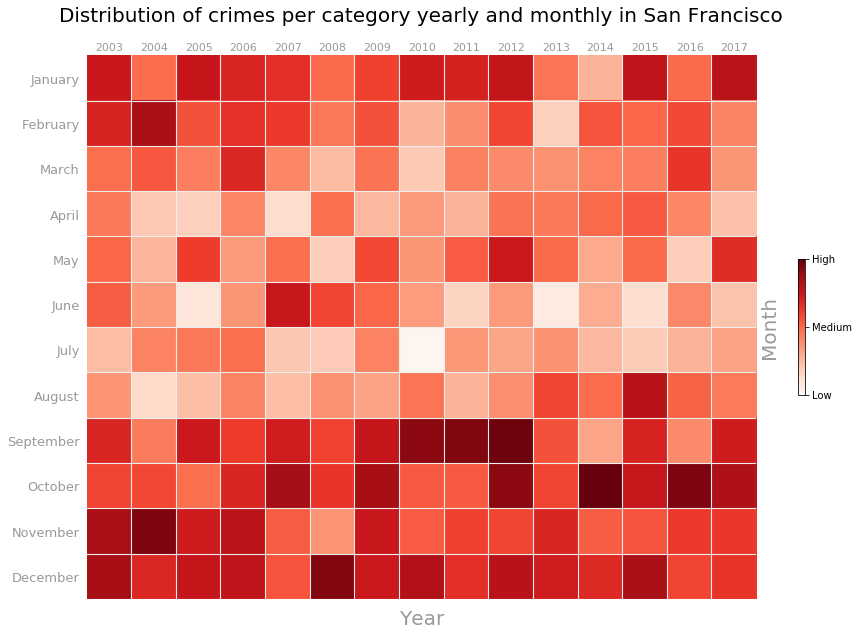

In [200]:
fig, ax = preparePlot(np.arange(.5, xlen, 1), np.arange(.5, ylen, 1), figsize=(15,10),\
                        hideLabels=True, gridColor='#eeeeee', gridWidth=1.1)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img,  aspect='auto', cmap=cm.Reds)

# x-axis labels
for x, y, s in zip(np.arange(-.30, xlen, 1), np.repeat(-.6, xlen), [str(x) for x in year]):
    plt.text(x, y, s, color='#999999', size='11')
# y-axis labels
for x, y, s in zip(np.repeat(-.65, ylen), np.arange(.125, ylen, 1), [str(x) for x in month]):
    plt.text(x, y, s, color='#999999', size='13', horizontalalignment="right")
# title, xlabel, ylabel
plt.title("Distribution of crimes per category yearly and monthly in San Francisco", size=20, y=1.05)
plt.xlabel("Year", color='#999999', size="20")
plt.ylabel("Month", color='#999999', size="20")

ax.yaxis.set_label_position("right")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.25, orientation='vertical')
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])

plt.show()

In [169]:
data.show()

+----------+----+-----+
|DayOfMonth|Hour|count|
+----------+----+-----+
|         1|   5|  766|
|         1|  18| 4282|
|         1|  12| 7079|
|         1|  16| 4016|
|         1|  23| 3236|
|         1|  21| 3355|
|         1|  17| 4257|
|         1|  11| 3147|
|         1|   8| 3909|
|         1|  19| 4035|
|         1|  20| 3527|
|         1|   3| 1355|
|         1|  14| 3526|
|         1|   2| 2211|
|         1|   4|  917|
|         1|   7| 1990|
|         1|  22| 3679|
|         1|   0|10074|
|         1|   1| 2796|
|         1|   9| 3878|
+----------+----+-----+
only showing top 20 rows



In [201]:
data2 = crimeDF.where((col('Hour').isNotNull())&(col('DayOfMonth').isNotNull()))\
.groupBy('DayOfMonth','Hour').count().orderBy('Hour','DayOfMonth')

In [202]:
week = np.arange(7)

day = np.arange(31)
xlen = len(day)
hour = np.arange(24)
ylen = len(hour)
count = data2.rdd.map(lambda x:x[2]).collect()
clen = len(count)

In [203]:
img2 = np.asarray(count,dtype=float)
#calculation of index between 0 and 1
maxc = np.amax(img)
minc = np.amin(img)
flow = maxc - minc
# np.subtract(img,np.repeat(np.amax(img),clen))
# np.divide(img,np.repeat(np.amax(img)-np.amin(img),clen))
for i in range(len(img)):
    img2[i] = (img2[i]-minc)/flow

img2 = img2.reshape(ylen,xlen)

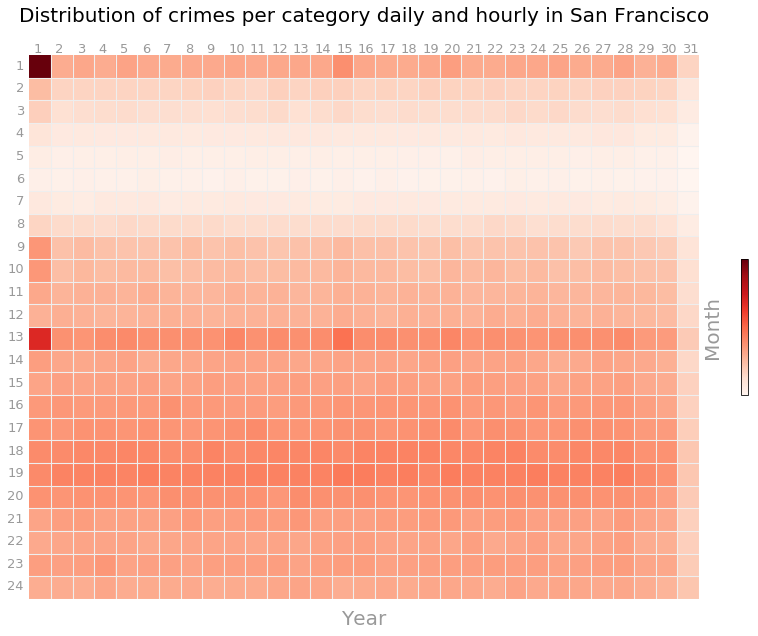

In [205]:
fig, ax = preparePlot(np.arange(.5, xlen, 1), np.arange(.5, ylen, 1), figsize=(15,10),\
                        hideLabels=True, gridColor='#eeeeee', gridWidth=1.1)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img2,  aspect='auto', cmap=cm.Reds)

# x-axis labels
for x, y, s in zip(np.arange(-.30, xlen, 1), np.repeat(-.6, xlen), [str(x+1) for x in day]):
    plt.text(x, y, s, color='#999999', size='13')
# y-axis labels
for x, y, s in zip(np.repeat(-.75, ylen), np.arange(.125, ylen, 1), [str(x+1) for x in hour]):
    plt.text(x, y, s, color='#999999', size='13', horizontalalignment="right")
# title, xlabel, ylabel
plt.title("Distribution of crimes per category daily and hourly in San Francisco", size=20, y=1.05)
plt.xlabel("Year", color='#999999', size="20")
plt.ylabel("Month", color='#999999', size="20")

ax.yaxis.set_label_position("right")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.25, orientation='vertical')
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])

plt.show()